In [13]:
import os
import gzip

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix

In [14]:
dataset_path = os.path.join(os.getcwd(), "MNIST")

In [15]:

def load_mnist(path, kind='train'):

    labels_path = os.path.join(path, f'{kind}-labels-idx1-ubyte.gz')
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    images_path = os.path.join(path, f'{kind}-images-idx3-ubyte.gz')
    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)

    return images, labels

In [16]:
train_set, train_label = load_mnist(dataset_path)
test_set, test_label = load_mnist(dataset_path, kind= 't10k')

### Categorie
```
0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot
```

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
random_seed = 1
torch.manual_seed(random_seed)

# tf=torchvision.transforms.Compose([
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize(  (0.1307,), (0.3081,) )
# ])

tf_noNorm=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [19]:
batch_size_train = 64
train_loader = DataLoader(tf_noNorm(train_set), batch_size=batch_size_train)

batch_size_test = 1000
test_loader = DataLoader(tf_noNorm(test_set), batch_size=batch_size_test, shuffle=True)

In [20]:
#Load train set
train_samples = enumerate(train_loader)
batch_idx, example_data = next(train_samples)

#Shape format: (Samples number, Channel, Y size, X Size)
example_data = example_data.reshape(train_set.shape[0], 1, 28, 28)

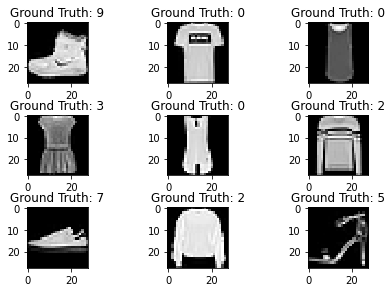

In [24]:
f, axs = plt.subplots(3,3)
plt.tight_layout()
k = 0
for i in range(3):
    for j in range(3):
        axs[i][j].imshow(train_samples[k][0], cmap='gray', interpolation='none')
        axs[i][j].set_title("Ground Truth: {}".format(train_label[k]))
        k += 1
plt.show()

Architettura della rete
La rete deve prendere in ingresso il vettore rappresentativo delle immagini e dare in output la classe della immagine, quindi:

input
28×28 

output
10 
una uscita per ogni classe

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [25]:
# Ottimizzatore
learning_rate = 0.01
momentum = 0.5 

network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

n_epochs = 3

In [ ]:
def train(train_loader, epoch, bs_train, net, opt, dir_results, tr_ls, tr_ct):
    net.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        # si azzerao i gradienti
        opt.zero_grad()
        # si calcola l'output della rete
        output = net(data)
        # si calcola l'errore con la funzione di loss
        loss = F.nll_loss(output, target)
        # si calcolano i gradienti
        loss.backward()
        # l'ottimizzaotre segue il passo di aprendimento
        opt.step()

        # print e report.........................
        if batch_idx % log_interval == 0:

            num_campioni_elaborati = batch_idx * len(data)
            num_campioni_totali = len(train_loader.dataset)
                        
            tr_ls.append(loss.item())

            totale_campioni_elaborati =  (batch_idx*bs_train) + (epoch-1)*num_campioni_totali 
        
            tr_ct.append( totale_campioni_elaborati )

            print('Train Epoch: {} [{}/{}  ({:.0f}%)]  \tLoss: {:.6f}'.format(
                epoch, num_campioni_elaborati, num_campioni_totali , 
                100. * batch_idx / len(train_loader), 
                loss.item()
                )
            )

            # salvataggio rete e ottimizzatore
            torch.save(network.state_dict(), dir_results + 'model.pth')
            torch.save(optimizer.state_dict(), dir_results + 'optimizer.pth')
        # fine print e report.........................    
         
    return tr_ls, tr_ct

In [26]:
# esegue un passo di test
def test(tls, net, test_ld):

    net.eval()
    test_loss = 0
    correct = 0

    # evita che si calcolino i gradienti
    with torch.no_grad():
        # visto che i dati di test sono 10.000 e il batch_size_tset e' 
        # 1000 la valutazione e' divisa in 10 passi 
        for data, target in test_ld:
            output = net(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(test_ld.dataset)
    tls.append(test_loss)

    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_ld.dataset),
        100. * correct / len(test_ld.dataset)))
    return tls